In [1]:
import os
import numpy as np
import pandas as pd
# import sklearn.linear_model as sklm
# import sklearn.model_selection as skms
# import sklearn.feature_selection
import sklearn.pipeline
# from sklearn.utils import shuffle
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Import our custom functions
from load_data import load_data 

Load training and validation data:

x data is an array of N*784 pixels (N = 2102 for tr, 600 for va)

y is a dataframe of index, class_name and class_id

In [10]:

x_tr, y_tr_df = load_data('x_train.csv', 'y_train.csv')
x_va, y_va_df = load_data('x_valid.csv', 'y_valid.csv')
x_te = load_data('x_test.csv', 'y_valid.csv')[0]


for label, arr in [('train', x_tr), ('valid', x_va)]:
    print("Contents of %s_x.csv: arr of shape %s" % (
        label, str(arr.shape)))

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


Plot a random image from the validation data for each category

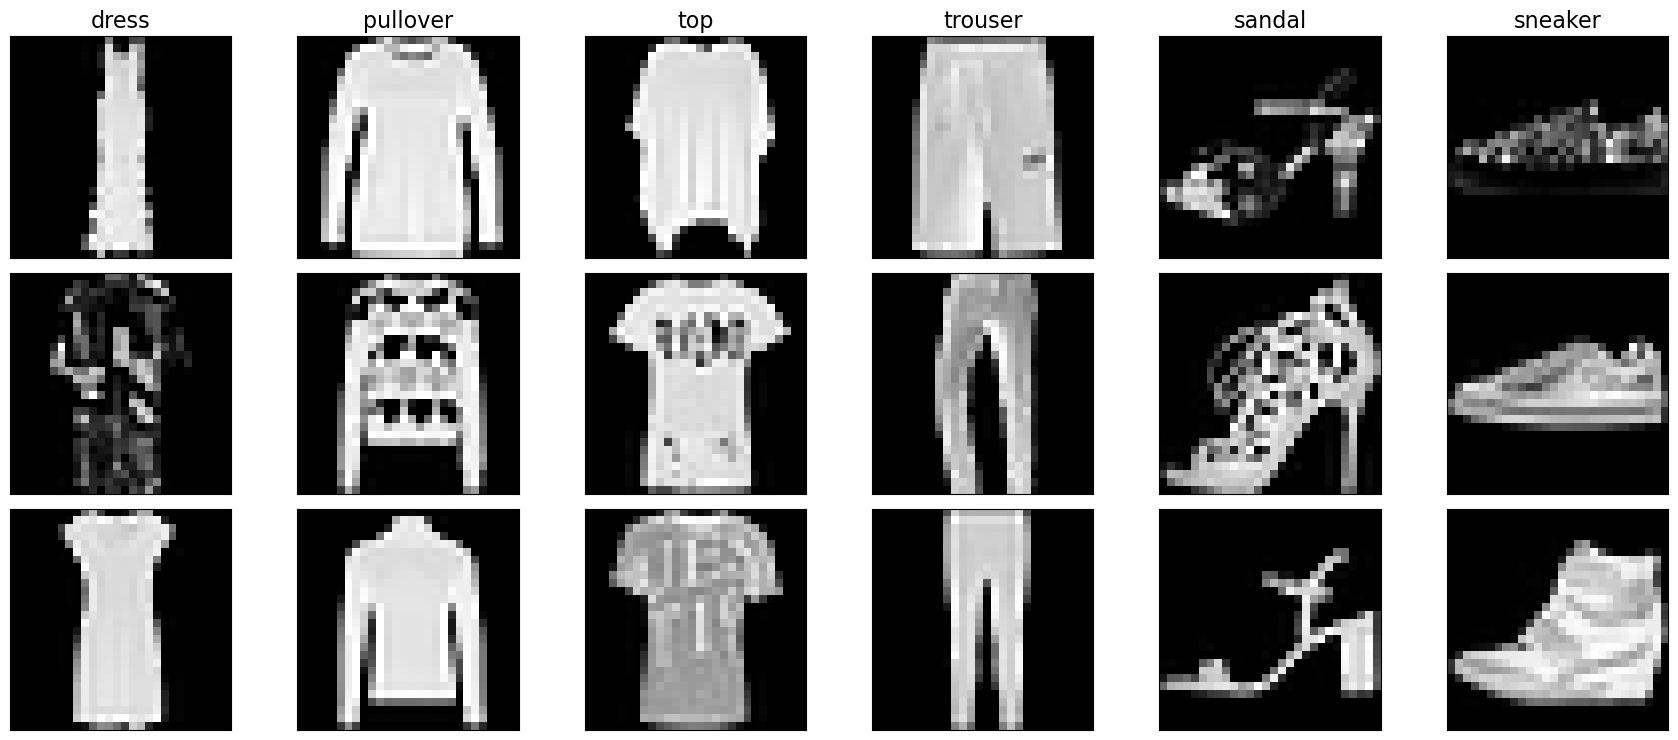

In [3]:
# prng = np.random.RandomState(0)
prng = np.random.RandomState()
N = 3 # num examples of each class to show
fig, axgrid = plt.subplots(N, 6, figsize=(6*3, N*2.5))

for ll, label in enumerate(['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']):
    match_df = y_va_df.query("class_name == '%s'" % label)
    match_ids_N = prng.choice(match_df.index, size=N)        
    for ii, row_id in enumerate(match_ids_N):
        ax = axgrid[ii, ll]
        x_SS = x_va[row_id].reshape((28,28))
        ax.imshow(x_SS, vmin=0, vmax=255, cmap='gray')
        ax.set_xticks([]); ax.set_yticks([]);
        if ii == 0:
            ax.set_title(label, fontsize=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=.2, hspace=.01)
plt.tight_layout();
plt.show();

# Data Exploration 1a

In [4]:
tr_class_dist = y_tr_df['class_name'].value_counts()
val_class_dist = y_va_df['class_name'].value_counts()

print('Training class distribution:')
print(tr_class_dist)
print('Validation class distribution:')
print(val_class_dist)

Training class distribution:
sandal      800
sneaker     800
dress       400
pullover    100
top           1
trouser       1
Name: class_name, dtype: int64
Validation class distribution:
dress       100
trouser     100
sandal      100
top         100
pullover    100
sneaker     100
Name: class_name, dtype: int64


The training data is heavily skewed with data from sandals and trainers, with only one training image for 2 classes. A challenge will be gaining a balanced weighting for each of the classes such that the dominant classes aren't always favoured by the classifier.

# Model

Run search with predefined split s.t. validation set is used for hyperparameter selection

In [5]:
# Combine training and validation datasets
x_all = np.vstack((x_tr,x_va))
y_all_df = pd.concat([y_tr_df,y_va_df])

print("Training X shape: %s\nValidation X shape: %s\nCombined X shape: %s\n" % (x_tr.shape, x_va.shape, x_all.shape))
print("Training Y shape: %s\nValidation Y shape: %s\nCombined Y shape: %s\n" % (y_tr_df.shape, y_va_df.shape, y_all_df.shape))

valid_indicators = np.hstack([
    -1 * np.ones(y_tr_df.shape[0]), # -1 means never include this example in any test split
    0  * np.ones(y_va_df.shape[0]), #  0 means include in the first test split (we count starting at 0 in python)
    ])

# Define custom splitter to use only the validation dataset for hyperparameter selection
print("Splitter dimensions: %i" % (valid_indicators.shape[0]))
my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators)


Training X shape: (2102, 784)
Validation X shape: (600, 784)
Combined X shape: (2702, 784)

Training Y shape: (2102, 2)
Validation Y shape: (600, 2)
Combined Y shape: (2702, 2)

(2702,)


In [6]:
param_dist = dict(activation=['relu', 'logistic', 'identity', 'tanh'], learning_rate_init=np.logspace(-5, 5, 100), learning_rate = ['constant','adaptive'], hidden_layer_sizes=[(20,),(50,),(100,),(200,),(500,)])

fashion_pipes = sklearn.pipeline.Pipeline([
    ('rand_search', RandomizedSearchCV(sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True), param_dist, scoring='balanced_accuracy', error_score='raise', random_state=0, return_train_score=True, n_iter=100, cv= my_splitter, n_jobs = -1))
])

fashion_pipes.fit(x_all, y_all_df['class_name'])

Pipeline(steps=[('rand_search',
                 RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                                    error_score='raise',
                                    estimator=MLPClassifier(early_stopping=True,
                                                            random_state=0,
                                                            solver='lbfgs'),
                                    n_iter=100, n_jobs=-1,
                                    param_distributions={'activation': ['relu',
                                                                        'logistic',
                                                                        'identity',
                                                                        'tanh'],
                                                         'hidden_layer_sizes': [(20,),
                                                                                (50,),
                                                                                (100,),
                                                                                (200,),
                                                                                (500,)],
                                                         'le...
       1.20450354e+03, 1.51991108e+03, 1.91791026e+03, 2.42012826e+03,
       3.05385551e+03, 3.85352859e+03, 4.86260158e+03, 6.13590727e+03,
       7.74263683e+03, 9.77009957e+03, 1.23284674e+04, 1.55567614e+04,
       1.96304065e+04, 2.47707636e+04, 3.12571585e+04, 3.94420606e+04,
       4.97702356e+04, 6.28029144e+04, 7.92482898e+04, 1.00000000e+05])},
                                    random_state=0, return_train_score=True,
                                    scoring='balanced_accuracy'))])

In [7]:
tr_acc = sklearn.metrics.balanced_accuracy_score(y_tr_df['class_name'], fashion_pipes['rand_search'].predict(x_tr))
va_acc = sklearn.metrics.balanced_accuracy_score(y_va_df['class_name'], fashion_pipes['rand_search'].predict(x_va))
print("Training balanced accuracy: %f\nValidation balanced accuracy: %f" % (tr_acc, va_acc))
    
fashion_pipes['rand_search'].cv_results_

Training balanced accuracy: 1.000000
Validation balanced accuracy: 1.000000


{'mean_fit_time': array([ 11.85251021,   9.39052463,  45.24148345,   8.46555972,
          5.60701513,   5.21823978,  63.3738606 ,   5.24563932,
         10.30297709,  12.98479009,   3.41015959,   6.88860774,
         69.80027676,   9.51001167,  18.60241914,  82.66042447,
         71.52085876,  23.35131884,  43.22243118,   7.89106321,
         26.18019795,  16.74945831,  23.32506967,  13.41661954,
         27.23432398,   6.59045219,   8.33559394,  14.19962645,
         51.57792974,  48.10057807,  65.72154498,   7.17030549,
         17.53749752,  14.32451677,  13.64799857,  75.90819907,
          5.6264863 ,  24.23008919,  22.17856765,  45.86451364,
          4.74000049, 106.69794798,  27.79120588,  13.33562398,
         77.14623809,  49.0622766 ,  96.54345846,  53.18191075,
         16.66817284,  72.02875233,  17.24317169,   8.93048334,
         14.55146194,  99.13877487,  20.22929144,  13.25925446,
          5.66826868, 102.3151176 ,   4.62327838,  20.15738869,
          7.93977666,  

In [22]:
best_est_1 = fashion_pipes['rand_search'].best_estimator_

pred_tr = best_est_1.predict(x_tr)
pred_va = best_est_1.predict(x_va)
pred_te = best_est_1.predict(x_te)


print(pred_te)

np.savetxt('yhat_test.txt', pred_te, delimiter='\n', fmt='%s')
# sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True)

['top' 'trouser' 'pullover' 'pullover' 'dress' 'top' 'sandal' 'top'
 'dress' 'sandal' 'dress' 'pullover' 'trouser' 'sandal' 'sneaker'
 'trouser' 'sneaker' 'sneaker' 'sneaker' 'trouser' 'trouser' 'dress'
 'pullover' 'top' 'pullover' 'top' 'dress' 'dress' 'pullover' 'dress'
 'pullover' 'pullover' 'dress' 'top' 'dress' 'sandal' 'trouser' 'trouser'
 'top' 'sandal' 'pullover' 'sneaker' 'dress' 'sandal' 'sneaker' 'trouser'
 'trouser' 'trouser' 'pullover' 'trouser' 'dress' 'pullover' 'pullover'
 'trouser' 'sandal' 'sneaker' 'dress' 'dress' 'pullover' 'pullover'
 'dress' 'pullover' 'sneaker' 'sandal' 'sandal' 'dress' 'pullover'
 'sneaker' 'sneaker' 'top' 'pullover' 'sneaker' 'dress' 'top' 'sandal'
 'sneaker' 'top' 'sandal' 'top' 'dress' 'trouser' 'sneaker' 'dress'
 'dress' 'dress' 'dress' 'pullover' 'pullover' 'sneaker' 'top' 'trouser'
 'dress' 'dress' 'dress' 'trouser' 'dress' 'dress' 'dress' 'sandal'
 'sneaker' 'sneaker' 'dress' 'dress' 'top' 'sneaker' 'pullover' 'pullover'
 'top' 'pullover'

![Balanced acc of 1.0 or tr and val](best_estimator_1.png)


In [ ]:
# normalize data - necessary ?
x_tr_norm = x_tr /255
x_va_norm = x_va /255


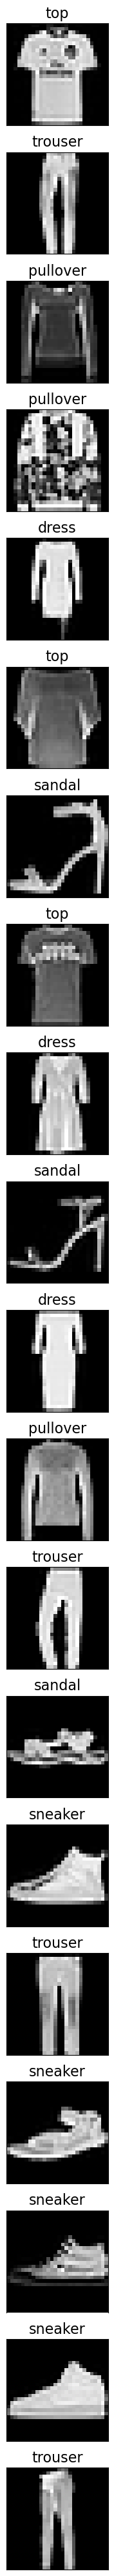

In [19]:
# Plot test data
x_te = load_data('x_test.csv', 'y_valid.csv')[0]

fig, axgrid = plt.subplots(20, 1, figsize=(20*30, 40))

for row_id in range(20):
    ax = axgrid[row_id]
    x_SS = x_te[row_id].reshape((28,28))
    ax.imshow(x_SS, vmin=0, vmax=255, cmap='gray')
    ax.set_xticks([]); ax.set_yticks([]);
    label = pred_te[row_id]
    ax.set_title(label, fontsize=16)
plt.tight_layout();
plt.show();